# 🏙️ 송도 국제도시 아파트 실거래가 부동산 분석 및 가격예측, 입지 추천 모델 개발


## 목적
1. 가격 변동 추이 파악: 송도의 아파트 실거래 데이터를 활용하여 시세흐름과 가격 변동성을 분석하여 주요 이벤트(GTX-B 개통 이슈, 국제도시 개발, 외국인 투자)와의 연관성 도출
2. 가격 예측 모델: 향후 아파트 가격 예측
3. 입지 추천 시스템 개발: 교통편의성(서울 접근성 VS 송도 내부 통근성), 교육/편의시설, 가격대 등을 종합적으로 고려한 거주, 투자자 맞춤형 지역, 단지 추천 (유사 입지 분석)

## 1. 데이터 수집 및 개별 전처리

### 1-1. 아파트 매매 실거래가 데이터
- **수집**: 공공 OPEN API를 통해 인천 연수구의 아파트 실거래 데이터를 연도별, 월별로 수집합니다.  
- **전처리**:  
  - **컬럼 및 데이터 타입**: XML 파싱을 통해 항목별 데이터를 추출하고, 첫 번째 데이터 요청 시 컬럼명을 설정합니다. 이후 거래 일자(연, 월, 일)를 합쳐서 `dealDate` 컬럼을 생성합니다.
  - **문자열 처리 및 숫자 변환**: `dealAmount`의 경우 쉼표를 제거하고, 실수형으로 변환하여 매매가격을 정량적으로 사용할 수 있게 합니다.
  - **파생 변수 생성**:  
    - `pricePerpy`: 평(3.3㎡) 단위로 가격을 계산하여, 단위 면적당 가격의 비교 가능성을 높입니다.
    - **로그 변환 및 이상치 제거**: 분포가 한쪽으로 치우친 매매가격 데이터를 로그 변환하고 IQR 기반 이상치 제거를 진행하여, 분석 시 정규분포에 가까운 데이터 분포를 만듭니다.

### 1-2. 주택현황 데이터 (연수구 주택 유형)
- **데이터 정제**: 인천 연수구 및 인천광역시 데이터를 대상으로 주택 수와 비율을 계산합니다.
- **시각화**: 파이 차트를 통해 아파트가 전체 주택 유형에서 약 92%를 차지함을 강조하고, 다른 주택 유형은 분석 대상에서 제외하는 근거를 마련합니다.

### 1-3. 교통 및 편의시설 데이터
- **교통 데이터**:  
  - 버스 정류소 및 지하철역 데이터를 다양한 CSV 파일에서 불러와, 승하차 정보와 정류소 위치(위도, 경도)를 정제하고 병합합니다.
  - API (카카오 API)를 활용하여 버스 정류소와 지하철역의 실제 위치(주소, 좌표)를 가져오며, 중복 컬럼 처리와 결측치 보정 과정을 거칩니다.
- **편의시설 데이터**:  
  - 카카오 및 TMAP API를 통해 송도 중심 지역의 카페, 음식점, 편의점 등 POI 데이터를 수집합니다.
  - 다양한 파일(예: `songdo_places_kakao.csv`, `songdo_small_store.csv`)을 병합하여 중복 제거 및 정제한 후 최종 편의시설 데이터셋을 구성합니다.

### 1-4. 금리 데이터
- **수집 및 웹 크롤링**:  
  - 한국은행 웹사이트에서 기준금리 정보를 BeautifulSoup을 이용해 크롤링하고, 테이블 데이터를 파싱합니다.
  - 거래 데이터와 금리 데이터를 연도/월 단위로 맞추기 위해 날짜 형식으로 변환하고, 이전 달 금리(전월세 전환율 적용과 유사한 개념)를 사용하여 병합합니다.
- **시장금리**:  
  - 국고채(10년) 데이터를 불러와, 전치(transpose) 과정을 거쳐 날짜별 시장금리를 산출하고, 연월 단위로 정리합니다.

### 1-5. 주택 보급률 데이터
- **인구 데이터**:  
  - 행정구역별 인구 데이터를 엑셀 파일에서 불러와서 정제한 후, 특정 기간(2015~2024년) 총인구수를 계산합니다.
- **주택 수 데이터**:  
  - IFEZ에서 제공한 주택 수 데이터를 활용하여, 예상 가구 수(평균 2.3명 가구 기준)를 산출하고, 주택 보급률(주택 수/추정 가구 수 × 100)을 계산합니다.

---


## 인천 연도별 주택현황 (아파트 매매만 다루는 이유)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

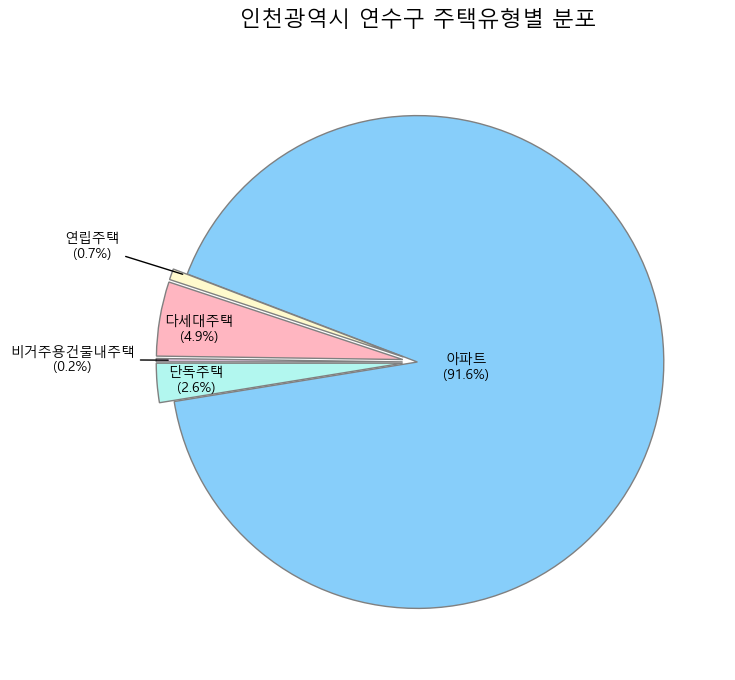

In [ ]:
songdo_house = pd.read_csv("songdo_house_data.csv")
songdo_house = songdo_house[['2023','항목','행정구역별(읍면동)']]
df = songdo_house[(songdo_house['행정구역별(읍면동)']=='연수구')|(songdo_house['행정구역별(읍면동)']=='인천광역시')]
df = df.rename(columns={"2023":"주택 수"})
# 연수구의 주택유형 비율
yeonsu_df = df[df['행정구역별(읍면동)']=='연수구'].copy()
yeonsu_total = yeonsu_df['주택 수'].sum()
yeonsu_df['비율(%)'] = (yeonsu_df['주택 수']/yeonsu_total)*100
# 색상지정
colors = ['#B2F7EF', '#87CEFA', '#FFFACD', '#FFB6C1', '#D8BFD8']

# 가독성 개선을 위한 원형 차트 수정
fig, ax = plt.subplots(figsize=(10, 8))

# 작은 값들을 더 강조하기 위해 explode 설정
explode = [0.06 if p < 10 else 0 for p in yeonsu_df["비율(%)"]]  # 작은 값만 약간 띄움

# 파이 차트 그리기 (explode 적용)
wedges, texts = ax.pie(
    yeonsu_df["비율(%)"], labels=None, autopct=None, startangle=180,
    colors=colors, pctdistance=0.85, wedgeprops={'linewidth': 1, 'edgecolor': 'gray'},
    explode=explode  # 작은 조각만 띄우기
)

# 항목 이름과 수치를 선으로 연결하여 표시 (위치 조정)
for wedge, label, percent in zip(wedges, yeonsu_df["항목"], yeonsu_df["비율(%)"]):
    theta = (wedge.theta2 + wedge.theta1) / 2.0  # 조각의 중심각

    # 아파트는 원 안쪽에 배치, 다세대주택은 원 바깥쪽으로 더 띄움
    if label == "아파트":
        x = np.cos(np.radians(theta)) * 0.2  # 원 안쪽 배치
        y = np.sin(np.radians(theta)) * 0.2
        ax.text(x, y, f"{label}\n({percent:.1f}%)", fontsize=10, ha='center', va='center')
    elif label == "다세대주택":
        x = np.cos(np.radians(theta)) * 0.9  # 내부 배치
        y = np.sin(np.radians(theta)) * 0.8
        ax.text(x, y, f"{label}\n({percent:.1f}%)", fontsize=10, ha='center', va='center')
    elif label == "단독주택":
        x = np.cos(np.radians(theta)) * 0.9  # 내부 위치
        y = np.sin(np.radians(theta)) * 0.9
        ax.text(x, y, f"{label}\n({percent:.1f}%)", fontsize=10, ha='center', va='center')
    else:
        x = np.cos(np.radians(theta)) * 1.4  # 기본 위치 (바깥쪽)
        y = np.sin(np.radians(theta)) * 1.4

        ax.annotate(
            f"{label}\n({percent:.1f}%)",
            xy=(np.cos(np.radians(theta)) * 1.0, np.sin(np.radians(theta)) * 1.05),  # 화살표 시작점
            xytext=(x, y),  # 화살표 끝점 (바깥쪽 이동)
            fontsize=10, ha='center', va='center',
            arrowprops=dict(arrowstyle="-", color="black")
        )


# 제목 설정 및 위치 조정
ax.set_title('인천광역시 연수구 주택유형별 분포', fontsize=16, pad=20)

# 그래프 출력
plt.show()

## 1. 데이터 수집 및 개별 전처리

### 1-1. 아파트 매매 실거래가 데이터
- **수집**: 공공 OPEN API를 통해 인천 연수구의 아파트 실거래 데이터를 연도별, 월별로 수집합니다.  
- **전처리**:  
  - **컬럼 및 데이터 타입**: XML 파싱을 통해 항목별 데이터를 추출하고, 첫 번째 데이터 요청 시 컬럼명을 설정합니다. 이후 거래 일자(연, 월, 일)를 합쳐서 `dealDate` 컬럼을 생성합니다.
  - **문자열 처리 및 숫자 변환**: `dealAmount`의 경우 쉼표를 제거하고, 실수형으로 변환하여 매매가격을 정량적으로 사용할 수 있게 합니다.
  - **파생 변수 생성**:  
    - `pricePerpy`: 평(3.3㎡) 단위로 가격을 계산하여, 단위 면적당 가격의 비교 가능성을 높입니다.
    - **로그 변환 및 이상치 제거**: 분포가 한쪽으로 치우친 매매가격 데이터를 로그 변환하고 IQR 기반 이상치 제거를 진행하여, 분석 시 정규분포에 가까운 데이터 분포를 만듭니다.

### 1-2. 주택현황 데이터 (연수구 주택 유형)
- **데이터 정제**: 인천 연수구 및 인천광역시 데이터를 대상으로 주택 수와 비율을 계산합니다.
- **시각화**: 파이 차트를 통해 아파트가 전체 주택 유형에서 약 92%를 차지함을 강조하고, 다른 주택 유형은 분석 대상에서 제외하는 근거를 마련합니다.

### 1-3. 교통 및 편의시설 데이터
- **교통 데이터**:  
  - 버스 정류소 및 지하철역 데이터를 다양한 CSV 파일에서 불러와, 승하차 정보와 정류소 위치(위도, 경도)를 정제하고 병합합니다.
  - API (카카오 API)를 활용하여 버스 정류소와 지하철역의 실제 위치(주소, 좌표)를 가져오며, 중복 컬럼 처리와 결측치 보정 과정을 거칩니다.
- **편의시설 데이터**:  
  - 카카오 및 TMAP API를 통해 송도 중심 지역의 카페, 음식점, 편의점 등 POI 데이터를 수집합니다.
  - 다양한 파일(예: `songdo_places_kakao.csv`, `songdo_small_store.csv`)을 병합하여 중복 제거 및 정제한 후 최종 편의시설 데이터셋을 구성합니다.

### 1-4. 금리 데이터
- **수집 및 웹 크롤링**:  
  - 한국은행 웹사이트에서 기준금리 정보를 BeautifulSoup을 이용해 크롤링하고, 테이블 데이터를 파싱합니다.
  - 거래 데이터와 금리 데이터를 연도/월 단위로 맞추기 위해 날짜 형식으로 변환하고, 이전 달 금리(전월세 전환율 적용과 유사한 개념)를 사용하여 병합합니다.
- **시장금리**:  
  - 국고채(10년) 데이터를 불러와, 전치(transpose) 과정을 거쳐 날짜별 시장금리를 산출하고, 연월 단위로 정리합니다.

### 1-5. 주택 보급률 데이터
- **인구 데이터**:  
  - 행정구역별 인구 데이터를 엑셀 파일에서 불러와서 정제한 후, 특정 기간(2015~2024년) 총인구수를 계산합니다.
- **주택 수 데이터**:  
  - IFEZ에서 제공한 주택 수 데이터를 활용하여, 예상 가구 수(평균 2.3명 가구 기준)를 산출하고, 주택 보급률(주택 수/추정 가구 수 × 100)을 계산합니다.

---


In [ ]:
# 아파트 매매 실거래가 전처리
songdo_apt_df = pd.read_csv("songdo_apt_data.csv")
print(songdo_apt_df.info())
print(songdo_apt_df.describe())
print(songdo_apt_df.head())

# 공백 개수 세기
def is_emptystring(x):
    return x.astype(str).str.strip().eq('').sum()
empty_cnt = songdo_apt_df.apply(lambda x: is_emptystring(x))
print(empty_cnt)

# 공백을 nan 값으로 만들기
songdo_apt_df = songdo_apt_df.replace(r'^\s*$',np.nan, regex=True)
empty_songdo_cnt = songdo_apt_df.apply(lambda x: is_emptystring(x))
print(empty_songdo_cnt)

songdo_apt_df = songdo_apt_df.replace(r'^\s*$',np.nan, regex=True)
songdo_apt_df['sdNm'] = songdo_apt_df.get('sdNm','인천광역시')
songdo_apt_df['sggNm'] = songdo_apt_df.get('sggNm','연수구')

# 데이터 타입 변경
songdo_apt_df[['dealYear','dealMonth','dealDay','floor','buildYear']] = songdo_apt_df[['dealYear','dealMonth','dealDay','floor','buildYear']].astype('int')
songdo_apt_df['dealAmount'] = songdo_apt_df['dealAmount'].astype(str).str.replace(',', '').astype(float)
songdo_apt_df[['excluUseAr']] = songdo_apt_df[['excluUseAr']].astype(float)
songdo_apt_df['dealDate'] = pd.to_datetime(songdo_apt_df[['dealYear','dealMonth','dealDay']].astype(str).agg('-'.join, axis=1))
songdo_apt_df['pricePerpy'] = (songdo_apt_df['dealAmount']/(songdo_apt_df['excluUseAr']/3.3)).round(4) # 평단가
songdo_apt_df.dtypes

xls = pd.ExcelFile(r"D:\project\songdo\yeonsugu_rent_conversion_rate.xlsx")
conversion_rate_df = pd.read_excel(xls, sheet_name="데이터")
songdo_apt_df.drop(['cdealDay', 'cdealType','sggCd','estateAgentSggNm', 'rgstDate', 'slerGbn','buyerGbn',  'dealingGbn', 'landLeaseholdGbn','aptDong','dealYear','dealMonth','dealDay'],axis=1 ,inplace=True)
songdo_apt_df = songdo_apt_df.reindex(['sdNm', 'sggNm', 'umdNm', 'jibun','aptNm', 'excluUseAr', 'dealDate', 'dealAmount', 'pricePerpy', 'floor', 'buildYear'],axis=1)
songdo_apt_df.isnull().sum()

In [ ]:
# 전월세전환율
# 데이터 변환 (연도-월을 행으로 정리)
conversion_rate_df = conversion_rate_df.melt(
    id_vars=["주택유형별(1)", "지역별(1)", "지역별(2)"],
    var_name="year_month",
    value_name="rent_conversion_rate"
)

# 인천 연수구 필터링
conversion_rate_df = conversion_rate_df[
    (conversion_rate_df["지역별(1)"] == "인천") & (conversion_rate_df["지역별(2)"] == "연수")
]

# 거래일에서 'YYYY.MM' 형태로 변환
songdo_apt_df["year_month"] = pd.to_datetime(songdo_apt_df["dealDate"]).dt.strftime("%Y.%m")

# 전월세 거래 데이터와 전월세전환율 병합 (left join)
songdo_apt_df = songdo_apt_df.merge(conversion_rate_df[["year_month", "rent_conversion_rate"]], 
                                      on="year_month", how="left")

In [ ]:
# 아파트 매매 실거래가 이상치 확인
# 송도 이상치 제거
songdo_apt_df = songdo_apt_df.loc[(songdo_apt_df['floor'] != -1) | ~((songdo_apt_df['aptNm'] == "송도웰카운티4단지") & (songdo_apt_df['floor']<6))]
songdo_apt_df.describe()
songdo_apt_df.to_csv("fin_apt_df.csv",index=False,encoding='utf-8-sig')

In [ ]:
import pandas as pd
import requests

# 데이터 로드 (CSV 파일 경로)
subway_raw_path = "인천교통공사_도시철도역사정보_2023-07-31.csv"
railway_address_path = "국가철도공단_인천_지하철_주소데이터_2020-11-23.csv"
subway_usage_1_path = "인천교통공사_1호선 일별 승하차현황_20240630.csv"
subway_usage_2_path = "인천교통공사_2호선 일별 승하차 현황_20240630.csv"
bus_raw_path = "인천광역시_시내버스 정류소 현황_2024-07-09.csv"
bus_passenger_raw_path = "인천광역시_정류장별 이용승객 현황_20250131.csv"

# 데이터 불러오기
subway_data = pd.read_csv(subway_raw_path, encoding="cp949")
railway_address = pd.read_csv(railway_address_path, encoding="cp949")
subway_usage_1 = pd.read_csv(subway_usage_1_path, encoding="cp949")
subway_usage_2 = pd.read_csv(subway_usage_2_path, encoding="cp949")
bus_data = pd.read_csv(bus_raw_path, encoding="cp949")
bus_passenger_data = pd.read_csv(bus_passenger_raw_path, encoding="cp949")

# 지하철 데이터 정리
subway_data = subway_data.drop(columns=["역번호", "영문역사명", "한자역사명"], errors="ignore")
subway_data.rename(columns={"역사명": "정류소명", "노선명": "노선/호선"}, inplace=True)

# 지하철 승하차 데이터 병합
subway_usage_data = pd.concat([subway_usage_1, subway_usage_2], ignore_index=True).drop_duplicates()
subway_usage_data.rename(columns={"역명": "정류소명"}, inplace=True)
subway_final = subway_data.merge(railway_address, left_on="정류소명", right_on="역명", how="left").drop(columns=["역명"])
subway_final = subway_final.merge(subway_usage_data, on="정류소명", how="left")

# 버스 데이터 정리
bus_data = bus_data.drop(columns=["정류소아이디"], errors="ignore")
bus_data["노선/호선"] = "버스"
bus_final = bus_data.merge(bus_passenger_data, on="정류소명", how="left")

# 카카오 API 활용하여 좌표 크롤링
KAKAO_API_KEY = "b4863b6c2ac0ffcff21852d82d421fa2"
url_keyword = "https://dapi.kakao.com/v2/local/search/keyword.json"
headers = {"Authorization": f"KakaoAK {KAKAO_API_KEY}"}

def get_location_data(station_names):
    results = []
    for station in station_names:
        params = {"query": station, "size": 1}
        response = requests.get(url_keyword, headers=headers, params=params)
        if response.status_code == 200:
            result = response.json().get("documents", [])
            if result:
                data = result[0]
                results.append({"정류소명": station, "위도": data.get("y", ""), "경도": data.get("x", "")})
    return pd.DataFrame(results)

# 버스 & 지하철 위치 데이터 수집
bus_api_data = get_location_data(bus_final["정류소명"].unique())
subway_api_data = get_location_data(subway_final["정류소명"].unique())

# 좌표 데이터 병합
bus_final = bus_final.merge(bus_api_data, on="정류소명", how="left")
subway_final = subway_final.merge(subway_api_data, on="정류소명", how="left")

# 최종 데이터 병합 및 컬럼 정리
final_data = pd.concat([bus_final, subway_final], ignore_index=True)
final_data = final_data.drop_duplicates(subset=["정류소명", "노선/호선"]).reset_index(drop=True)

# 최적화된 데이터 저장
final_output_path = "final_transport_data_complete.csv"
final_data.to_csv(final_output_path, index=False, encoding="utf-8")


# 중복 데이터 제거
df = final_data.drop_duplicates(subset=['정류소명', '정류소번호'])

# 데이터 타입 변환
df['기준일자'] = pd.to_datetime(df['기준일자'], format='%Y%m%d', errors='coerce')
df['정류소번호'] = df['정류소번호'].fillna(0).astype(int)
df['정류소아이디'] = df['정류소아이디'].fillna(0).astype(int)


# 위도, 경도 정리 (소수점 5자리까지 반올림, 역위도/역경도 포함)
df['위도'] = df[['위도_x', '위도_y', '역위도']].bfill(axis=1).iloc[:, 0].round(5)
df['경도'] = df[['경도_x', '경도_y', '역경도']].bfill(axis=1).iloc[:, 0].round(5)

# 컬럼명 정리 (공백 및 특수문자 제거)
df.columns = df.columns.str.strip()

df = df.drop(columns=['기준일자', '정류소번호', '위도_x', '경도_x','엑스좌표','와이좌표', '노선/호선', '위도_y', '경도_y', '노선번호',
       '역위도_x', '역경도_x', '운영기관명_x', '역사도로명주소', '역사전화번호', '데이터기준일자', '철도운영기관명', '일자',
        '위도', '경도', '역위도_y', '역경도_y', '운영기관명_y','승차건수(카드)','하차건수(카드)'], errors='ignore')

# NaN 값이 있는 경우 승차인원과 하차인원 값으로 채우기
df['총승차건수'] = df['총승차건수'].fillna(df['승차인원'])
df['총하차건수'] = df['총하차건수'].fillna(df['하차인원'])

# '행정동명' 컬럼에서 '송도동'이 포함된 행 필터링
df_songdo = df[df['지번주소'].astype(str).str.contains('송도동', na=False)]
df_songdo = df[df['권역'].astype(str).str.contains('연수구', na=False)]
df_songdo = df[df['행정동명'].astype(str).str.contains('송도', na=False)]

col = ['승차건수(현금)','환승역구분','환승노선번호','환승노선명','역위도','역경도','운영기관명','선명','지번주소','도로명주소','이용인원','승차인원','하차인원']
df_songdo = df_songdo.drop(columns=col)

df.rename(columns={'latitude': 'trans_latitude', 'longitude': 'trans_longitude'}, inplace=True)

df.to_csv('fin_transport5.csv',index=False, encoding='utf-8-sig')

In [ ]:
## 소규모 상권
import requests
import pandas as pd
import time

# 📌 카카오 API 키 (Kakao Developers에서 발급받은 키를 입력하세요)
KAKAO_API_KEY = ""

# 장소 검색 API 요청 함수
def search_places(keyword, x, y, radius=1000, page=1):
    """
    카카오맵 API를 이용해 특정 지역 반경 내 장소 정보를 검색하는 함수.
    :param keyword: 검색할 키워드 (예: '카페', '편의점')
    :param x: 중심 좌표 (경도)
    :param y: 중심 좌표 (위도)
    :param radius: 검색 반경 (미터 단위, 최대 10000)
    :param page: 페이지 번호
    :return: 검색된 장소 정보 (DataFrame 형태)
    """
    url = "https://dapi.kakao.com/v2/local/search/keyword.json"
    headers = {"Authorization": f"KakaoAK {KAKAO_API_KEY}"}
    params = {
        "query": keyword,
        "x": x,
        "y": y,
        "radius": radius,
        "page": page,
        "size": 15  # 한 페이지에 최대 15개까지 가능
    }

    response = requests.get(url, headers=headers, params=params)
    result = response.json()

    # 에러 처리
    if "documents" not in result:
        print("API 요청 오류:", result)
        return pd.DataFrame()

    # 장소 데이터 저장
    places = []
    for place in result["documents"]:
        places.append({
            "장소명": place["place_name"],
            "카테고리": place["category_name"],
            "주소": place["address_name"],
            "도로명주소": place["road_address_name"],
            "위도": place["y"],
            "경도": place["x"],
            "전화번호": place["phone"],
            "장소 URL": place["place_url"]
        })

    return pd.DataFrame(places)

# 📌 송도 중심 좌표 (예시)
songdo_x, songdo_y = "126.64894", "37.38265"

# 📌 검색할 키워드 목록 (유동인구가 많은 장소)
keywords = ["카페", "편의점", "식당", "지하철역", "버스정류장"]

# 📌 데이터 수집
all_places = []
for keyword in keywords:
    print(f"🔍 '{keyword}' 데이터 수집 중...")
    for page in range(1, 4):  # 3페이지까지 검색 (최대 45개)
        df = search_places(keyword, songdo_x, songdo_y, radius=2000, page=page)
        if df.empty:
            break
        all_places.append(df)
        time.sleep(0.5)  # API 요청 속도 조절

# 📌 데이터 합치기
final_df = pd.concat(all_places, ignore_index=True)

# 📌 CSV 저장
final_df.to_csv("songdo_places_kakao.csv", index=False, encoding="utf-8-sig")

print("✅ 데이터 수집 완료! 저장 파일: songdo_places_kakao.csv")

import requests
import pandas as pd
import time

# 🔹 카카오 API 키 (발급 후 입력)
KAKAO_API_KEY = ""

# 🔹 검색할 카테고리 목록 (카페, 음식점, 편의점 등)
CATEGORY_GROUPS = {
    "카페": "CE7",
    "음식점": "FD6",
    "편의점": "CS2"
}

# 🔹 검색할 중심 좌표 (송도 지역 중심 좌표 설정)
center_lat, center_lng = 37.3925, 126.6360  # 송도 센트럴파크 기준

# 🔹 반경 설정 (단위: 미터, 최대 20,000m)
radius = 1000  

# 🔹 API 요청 함수
def get_places(category_code, lat, lng, radius=1000):
    url = "https://dapi.kakao.com/v2/local/search/category.json"
    headers = {"Authorization": f"KakaoAK {KAKAO_API_KEY}"}
    params = {
        "category_group_code": category_code,
        "x": lng,  # 경도
        "y": lat,  # 위도
        "radius": radius,
        "sort": "distance",  # 거리순 정렬
        "page": 1
    }

    results = []
    while True:
        response = requests.get(url, headers=headers, params=params)
        data = response.json()
        
        if "documents" not in data:
            break

        results.extend(data["documents"])

        # 다음 페이지 확인
        if len(data["documents"]) < 15:
            break  # 마지막 페이지 도달

        params["page"] += 1
        time.sleep(0.3)  # API 요청 속도 조절

    return results

# 🔹 데이터 수집 실행
all_places = []
for category, code in CATEGORY_GROUPS.items():
    print(f"🔍 {category} 데이터 수집 중...")
    places = get_places(code, center_lat, center_lng, radius)
    for place in places:
        all_places.append({
            "시설명": place["place_name"],
            "유형": category,
            "주소": place["road_address_name"] or place["address_name"],
            "위도": place["y"],
            "경도": place["x"],
            "연락처": place.get("phone", None)
        })

# 🔹 데이터프레임으로 변환 후 저장
df = pd.DataFrame(all_places)
df.to_csv("songdo_small_store.csv", index=False, encoding="utf-8-sig")
print("✅ 데이터 수집 완료! 파일 저장됨.")

import requests
import pandas as pd
import time

# 카카오 API 키 (Kakao Developers에서 발급받은 키를 입력하세요)
KAKAO_API_KEY = ""

# 카카오 API 요청 헤더 설정
headers = {
    "Authorization": f"KakaoAK {KAKAO_API_KEY}"
}

# 카카오 장소(POI) 검색 함수 (키워드 기반)
def get_places_by_keyword(query, x, y, radius=3000):
    url = "https://dapi.kakao.com/v2/local/search/keyword.json"
    params = {
        "query": query,
        "x": x,
        "y": y,
        "radius": radius,
        "size": 15
    }
    response = requests.get(url, headers=headers, params=params)
    return response.json() if response.status_code == 200 else None

# 카카오 카테고리 검색 함수 (특정 업종)
def get_places_by_category(category, x, y, radius=3000):
    url = "https://dapi.kakao.com/v2/local/search/category.json"
    params = {
        "category_group_code": category,
        "x": x,
        "y": y,
        "radius": radius,
        "size": 15
    }
    response = requests.get(url, headers=headers, params=params)
    return response.json() if response.status_code == 200 else None

# 송도 지역에서 데이터 수집하기
def collect_songdo_data():
    # 🚩 송도 센트럴파크 기준
    SONGDO_X, SONGDO_Y = "126.64894", "37.38265"

    # 주요 장소 검색 (음식점, 카페, 병원, 편의점 등)
    keywords = ["편의점", "카페", "음식점", "병원", "대형마트", "문화시설"]
    places_data = []

    for keyword in keywords:
        result = get_places_by_keyword(keyword, SONGDO_X, SONGDO_Y)
        if result and "documents" in result:
            for place in result["documents"]:
                places_data.append({
                    "장소명": place["place_name"],
                    "카테고리": place["category_name"],
                    "주소": place["address_name"],
                    "위도": place["y"],
                    "경도": place["x"]
                })
        time.sleep(1)

    # 특정 카테고리 검색 (카카오 카테고리 코드 활용)
    category_codes = ["CS2", "FD6", "CE7", "MT1", "CT1", "HP8"]  # 편의점, 음식점, 카페, 대형마트, 문화시설, 병원
    for category in category_codes:
        result = get_places_by_category(category, SONGDO_X, SONGDO_Y)
        if result and "documents" in result:
            for place in result["documents"]:
                places_data.append({
                    "장소명": place["place_name"],
                    "카테고리": place["category_name"],
                    "주소": place["address_name"],
                    "위도": place["y"],
                    "경도": place["x"]
                })
        time.sleep(1)

    # 데이터 저장
    places_df = pd.DataFrame(places_data)
    places_df.to_csv("songdo_kakao_poi_data.csv", index=False, encoding="utf-8-sig")
    print("✅ 송도 카카오 상권 데이터 저장 완료! (songdo_kakao_poi_data.csv)")

# 전체 실행
if __name__ == "__main__":
    collect_songdo_data()

import pandas as pd

# 파일 목록
poi_files = [
    "songdo_places_kakao.csv",
    "songdo_kakao_poi_data.csv",
    "songdo_small_store.csv"
]

# 데이터 병합
poi_dfs = []
for file in poi_files:
    try:
        df = pd.read_csv(file)
        if not df.empty:  # 비어 있지 않은 데이터만 추가
            poi_dfs.append(df)
    except Exception as e:
        print(f"❌ {file} 제외 (오류: {e})")

# 데이터 병합
if poi_dfs:
    merged_poi_df = pd.concat(poi_dfs, ignore_index=True)
    merged_poi_df = merged_poi_df.drop_duplicates()
    print("✅ 데이터 병합 완료!")
else:
    print("⚠️ 사용 가능한 데이터가 없습니다.")

# 데이터 저장
# merged_poi_df.to_csv("merged_poi_data.csv", index=False)

# 📌 데이터 병합 (중복 제거)
if poi_dfs:
    merged_poi_df = pd.concat(poi_dfs, ignore_index=True)
    merged_poi_df = merged_poi_df.drop_duplicates(subset=['위도', '경도'], keep='first')
    print("✅ 데이터 병합 완료!")
else:
    print("⚠️ 사용 가능한 데이터가 없습니다.")

# 새로 추가된 파일 병합
new_poi_file = "fin_convenience_df.csv"

try:
    new_poi_df = pd.read_csv(new_poi_file)
    if not new_poi_df.empty:
        merged_poi_df = pd.concat([merged_poi_df, new_poi_df], ignore_index=True)
        merged_poi_df = merged_poi_df.drop_duplicates(subset=['위도', '경도'], keep='first')
        print("✅ 새로운 데이터 포함하여 병합 완료!")
    else:
        print("⚠️ 추가된 파일이 비어 있습니다.")
except Exception as e:
    print(f"❌ 추가된 파일을 불러오는 데 실패했습니다: {e}")

# 불필요한 컬럼 삭제
drop_col = ['카테고리', '도로명주소', '전화번호', '장소 URL', '유형', '연락처']
merged_poi_df = merged_poi_df.drop(columns=[col for col in drop_col if col in merged_poi_df.columns])

# 최종 저장
df.rename(columns={'latitude': 'conv_latitude', 'longitude': 'conv_longitude'}, inplace=True)
df.to_csv('fin_convenience5.csv',index=False, encoding='utf-8-sig')

In [ ]:
# 기준 금리 구하기
import requests
from bs4 import BeautifulSoup
import pandas as pd
url = 'https://www.bok.or.kr/portal/singl/baseRate/list.do?dataSeCd=01&menuNo=200643'
r=requests.get(url)
header = {'User_Agent':"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36"}
data = requests.get(url, headers=header)

soup = BeautifulSoup(data.text, 'html.parser')
print(soup)

# 테이블 데이터 찾기
table = soup.find("table",class_="fixed")
rows = soup.find('tbody').find_all('tr')

# 데이터 저장용 리스트
df = []

for row in rows:
    cols = row.find_all('td')
    year = cols[0].text.strip()
    date = cols[1].text.strip()
    rate = float(cols[2].text.strip())

    df.append([year,date,rate])
rate_df = pd.DataFrame(df,columns=['년도','변경일자','기준금리'])
latest_rates = rate_df.groupby("년도").first().reset_index()
latest_rates.to_csv("rate.csv",index=False, encoding='utf-8-sig')
df = latest_rates.copy()
df['변경일자'] = df['년도'].astype(str)+ '-' + df['변경일자'].replace({'월 ':'-','일':''}, regex=True).strip().astype(str) # 패턴기반 변환
df
df.drop(columns='년도',inplace=True)
df.to_csv("intrest_rate.csv",index=False,encoding='utf-8-sig')
import pandas as pd

# 기준금리 데이터 불러오기
rate_df = pd.read_csv("interest_rates.csv")
rate_df['변경일자'] = pd.to_datetime(rate_df['변경일자'])
rate_df['year_month'] = rate_df['변경일자'].dt.to_period('M')

# 기준금리 데이터 전처리 (이전 달 기준으로 적용)
rate_df['prev_year_month'] = rate_df['year_month'] - 1  # 이전 달 생성
rate_monthly = rate_df.groupby('prev_year_month')['기준금리'].last().reset_index()
rate_monthly.rename(columns={'prev_year_month': 'year_month'}, inplace=True)

# 국고채(시장금리) 데이터 불러오기 및 전처리
bond_yield_df = pd.read_csv("bond_yield.csv")
bond_yield_df_filtered = bond_yield_df[bond_yield_df['항목명1'] == '국고채(10년)'].iloc[:, 5:].T
bond_yield_df_filtered.columns = ['Market Interest Rate']
bond_yield_df_filtered.index = pd.to_datetime(bond_yield_df_filtered.index, format='%Y/%m')
bond_yield_df_filtered['year_month'] = bond_yield_df_filtered.index.to_period('M')

# 기준금리, 국고채 금리 데이터 병합
merged_df = rate_monthly.merge(bond_yield_df_filtered.reset_index()[['year_month', 'Market Interest Rate']], on='year_month', how='left')
merged_df.rename(columns={'기준금리': 'Policy Rate'}, inplace=True)

# 기준금리 NaN 값 보정 (ffill -> bfill 적용)
merged_df['Policy Rate'] = merged_df['Policy Rate'].fillna(method='ffill')  # 이전 값으로 채우기
merged_df['Policy Rate'] = merged_df['Policy Rate'].fillna(method='bfill')  # 이후 값으로 채우기

# 저장
output_path = "merged_real_estate_interest_bond.csv"
merged_df.to_csv(output_path, index=False)

print(f"Merged data saved to {output_path}")

In [ ]:
# GTX-B 노선 이슈 정리 (더미변수)
# 국가철도공단: 사업소개 - 광역철도 - 주요사업현황 - 수도권 광역급행철도 B노선(BTO)
# https://www.kr.or.kr/sub/info.do?m=05010402&utm_source=chatgpt.com
import pandas as pd
# 월과 주요 일정 항목의 길이를 맞추기 위해 수정된 데이터 정의
data = {
    '연도': ['2011', '2011', '2014', '2017', '2019', '2020', '2021', '2022', '2022', '2022', '2023', '2023', '2023', '2024', '2024', '2024'],
    '월': ['4', '12', '2', '8', '8', '1', '8', '7', '11', '11', '1', '6', '12', '2', '3', '4'],
    '주요 일정': [
        '제2차 국가철도망구축계획(\'11~\'20) 전반기 착수사업 선정',
        '예비타당성 조사 착수',
        '예비타당성 조사 결과 B/C 0.33으로 탈락',
        '수도권광역급행철도 B노선 예타 대상사업 재신청 및 선정',
        '예비타당성 조사 통과(B/C 1.0, AHP 0.540)',
        '타당성조사 및 기본계획 용역 시행 시작 (국토교통부)',
        '타당성조사 및 기본계획 용역 완료',
        '민자구간 시설사업기본계획 고시(국토부고시 제2022-397호)',
        '민자구간 시설사업기본계획 재고시(국토부고시 제2022-627호)',
        '시설사업기본계획(RFP) 고시 및 협상',
        '우선협상대상자 선정 및 협상 착수',
        '실시설계 착수',
        '재정사업(용산~상봉) 구간 착공',
        '민간투자심의위원회 통과(KDI)',
        'GTX-B 착공식 및 협약식',
        'GTX-B(민자구간) 실시계획 승인 신청'
    ]
}

# 수정된 데이터프레임 생성
df = pd.DataFrame(data)

# 출력
df.to_csv("gtx_issue.csv", index=False, encoding='utf-8-sig')
